In [1]:
import warnings
warnings.filterwarnings('ignore')
from model import cnn_model
import numpy as np
import pandas as pd
import keras
import matplotlib.pyplot as plt
import seaborn as sns
import collections as cll
import itertools
import glob
import os
from sklearn.model_selection import train_test_split
from keras.utils import np_utils
from keras.models import Sequential
from keras import regularizers
from keras.layers import Dense, Dropout, Activation, Conv2D, Flatten, BatchNormalization, AveragePooling2D
from keras.optimizers import SGD
from keras.optimizers import Adam, Nadam, Adadelta
from keras.models import load_model
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.metrics import classification_report,confusion_matrix
from keras.datasets import mnist
from keras.utils import Sequence

class My_generator(Sequence):
    def __init__(self, x_set_dir, y_set, batch_size):
        self.x, self.y = x_set_dir, y_set
        self.batch_size = batch_size
        
    def __len__(self):
        return int(np.ceil(len(self.x) / float(self.batch_size)))
    
    def __getitem__(self, idx):
        batch_x = self.x[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_y = self.y[idx * self.batch_size:(idx + 1) * self.batch_size]
        # read your data here using the batch lists, batch_x and batch_y
        x = [np.load(filename) for filename in batch_x] 
        y = [np.load(filename) for filename in batch_y]
    
        return np.array(x).reshape(batch_size,img_rows,img_cols,1), np.array(y) 

Using TensorFlow backend.


In [2]:
def cnn_model(input_dim, n_classes, init,drop):
    model = Sequential()
    model.add(Conv2D(128, (4, 4), strides=(1, 1), kernel_initializer=init , padding='same', activation='relu', input_shape=input_dim))
    model.add(Conv2D(128, (4, 4), strides=(1, 1), kernel_initializer=init , padding='same', activation='relu'))
    model.add(AveragePooling2D(pool_size=(9,1)))
    model.add(Dropout(drop))
    
    model.add(Conv2D(256, (3,3), strides=(1, 1), kernel_initializer=init , activation='relu'))
    model.add(Conv2D(256, (3,3), strides=(1, 1), kernel_initializer=init , padding='same', activation='relu'))
    model.add(AveragePooling2D(pool_size=(7,1)))
    model.add(Dropout(drop))
    
    model.add(Conv2D(512, (3,3), strides=(1, 1), kernel_initializer=init , padding='same', activation='relu'))
    model.add(Conv2D(512, (3,3), strides=(1, 1), kernel_initializer=init , padding='same', activation='relu'))
    model.add(AveragePooling2D(pool_size=(5,1)))
    model.add(Dropout(drop))
    
    model.add(Conv2D(768, (3,3), strides=(1, 1), kernel_initializer=init,activation='relu'))
    model.add(Conv2D(768, (3,3), strides=(1, 1), kernel_initializer=init, padding='same', activation='relu'))
    model.add(AveragePooling2D(pool_size=(3,1)))
    model.add(Dropout(drop))
    
    model.add(Flatten())
    model.add(Dense(4096, kernel_initializer=init , activation='relu'))
    model.add(Dropout(drop*6))

    model.add(Dense(768, kernel_initializer=init , activation='relu'))
    model.add(Dropout(drop*2))

    return model

In [3]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    fig = plt.figure()
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)

    fmt = '.4f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('Classe correta')
    plt.xlabel('Classe prevista')
    
    return fig

In [4]:
img_rows, img_cols = 6410, 8
n_classes = 5
input_shape = (img_rows, img_cols, 1)

# B2

In [5]:
train_path = glob.glob(os.path.join('dados/train/', '*.npy'))
test_path = glob.glob(os.path.join('dados/test', '*.npy'))
y_train_dir = glob.glob(os.path.join('labels/B2_y_train/', '*.npy'))
y_test_dir = glob.glob(os.path.join('labels/B2_y_test/', '*.npy'))

In [7]:
X_train_test = train_path + test_path
y_train_test = y_train_dir + y_test_dir

In [8]:
batch_size = 1
my_traintest_gen = My_generator(X_train_test,y_train_test,1)
my_training_batch_generator = My_generator(train_path, y_train_dir, batch_size)
my_validation_batch_generator = My_generator(test_path, y_test_dir, batch_size)

In [9]:
init = keras.initializers.lecun_normal(42)
init2 = keras.initializers.constant(0.001)
model = cnn_model(input_shape,n_classes,init,0.01)
model.add(Dense(n_classes,activation='softmax'))
model.load_weights('PesosB2/cruzinho-vgg.128-1.04-0.73-3.96-0.41.hdf5')
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 6410, 8, 128)      2176      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 6410, 8, 128)      262272    
_________________________________________________________________
average_pooling2d_1 (Average (None, 712, 8, 128)       0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 712, 8, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 710, 6, 256)       295168    
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 710, 6, 256)       590080    
_________________________________________________________________
average_pooling2d_2 (Average (None, 101, 6, 256)       0         
__________

In [10]:
sgd = SGD(lr=0.1, decay=0, momentum=0.9, nesterov=True)
adam = Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0, amsgrad=False)
nadam = Nadam(lr=0.00005, beta_1=0.90, beta_2=0.999, epsilon=None, schedule_decay=0.004)
adadelta = Adadelta(lr = 1)
filepath = 'PesosB2/cruzinho-vgg.{epoch:02d}-{loss:.2f}-{acc:.2f}.hdf5'
cb = keras.callbacks.ModelCheckpoint(filepath, monitor='acc', verbose=0, save_best_only=True, save_weights_only=True, mode='auto', period=1)

model.compile(optimizer = nadam, loss = 'categorical_crossentropy', metrics = ['accuracy'])

In [19]:
history = model.fit_generator(generator=my_traintest_gen,
                                          epochs=157,
                                          verbose=1,
                                          use_multiprocessing=True,
                                          workers = 8,
                                          validation_data=my_validation_batch_generator,
                                          validation_steps=(len(test_path) // batch_size),
                                          steps_per_epoch=(len(X_train_test) // 1),
                                          callbacks = [cb],
                                          initial_epoch=155)

Epoch 156/157
7865/7865 [==============================] - 2459s 313ms/step - loss: 1.5698 - acc: 0.6587 - val_loss: 2.0849 - val_acc: 0.5194
Epoch 157/157
7865/7865 [==============================] - 2457s 312ms/step - loss: 1.4255 - acc: 0.6626 - val_loss: 1.8872 - val_acc: 0.5257
Epoch 157/157


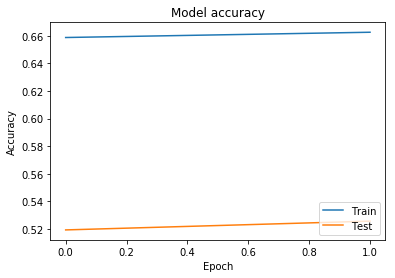

In [20]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='lower right')
plt.show()

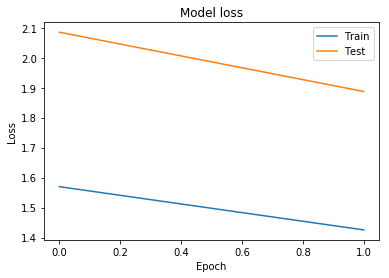

In [21]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper right')
plt.show()

In [22]:
y_test = []
y_train = []

for i in y_test_dir:
    tmp = np.load(i)
    y_test.append(tmp)

for i in y_train_dir:
    tmp = np.load(i)
    y_train.append(tmp)

1573/1573 [==============================] - 58s 37ms/step
              precision    recall  f1-score   support

           0     0.4465    0.7947    0.5717       341
           1     0.5326    0.3043    0.3874       322
           2     0.5827    0.5326    0.5566       291
           3     0.6580    0.4205    0.5131       302
           4     0.5449    0.5552    0.5500       317

   micro avg     0.5257    0.5257    0.5257      1573
   macro avg     0.5529    0.5215    0.5158      1573
weighted avg     0.5498    0.5257    0.5155      1573

CPU times: user 15.1 s, sys: 4.16 s, total: 19.2 s
Wall time: 57.9 s


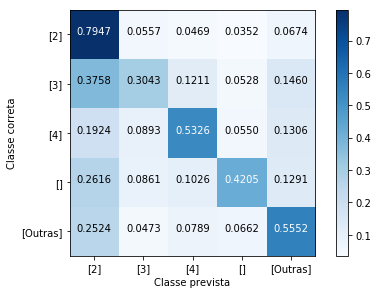

In [26]:
%%time
#Predict Test
classes = ['[2]', '[3]', '[4]', '[]', '[Outras]']
y_testing = np.argmax(y_test, axis =1)
pred = model.predict_generator(my_validation_batch_generator, workers=8, use_multiprocessing=True, verbose=1,max_queue_size=64, steps=(len(test_path) // batch_size))
pred = np.argmax(pred, axis = 1)
print(classification_report(y_testing,pred,digits=4))
cm = confusion_matrix(y_testing,pred)
cm_plot = plot_confusion_matrix(cm, classes, normalize=True, title='')
cm_plot.savefig('cruzin_b2_test.png',dpi = 'figure', bbox_inches='tight')

6292/6292 [==============================] - 243s 39ms/step
              precision    recall  f1-score   support

           0     0.4885    0.9343    0.6416      1232
           1     0.8866    0.4812    0.6238      1251
           2     0.8895    0.7785    0.8303      1282
           3     0.9126    0.6987    0.7914      1271
           4     0.7668    0.7094    0.7370      1256

   micro avg     0.7200    0.7200    0.7200      6292
   macro avg     0.7888    0.7204    0.7248      6292
weighted avg     0.7906    0.7200    0.7258      6292



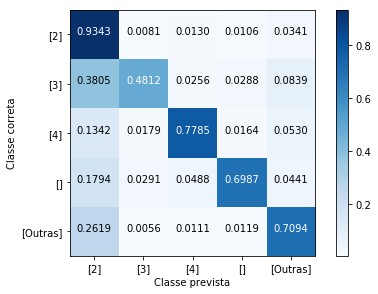

In [27]:
#Predict Train
y_training = np.argmax(y_train, axis = 1)
pred = model.predict_generator(my_training_batch_generator, workers=8, use_multiprocessing=True, verbose=1,max_queue_size=64, steps=(len(train_path) // batch_size))
pred = np.argmax(pred, axis = 1)
print(classification_report(y_training,pred,digits=4))
cm = confusion_matrix(y_training,pred)
cm_plot = plot_confusion_matrix(cm, classes, normalize=True, title='')
cm_plot.savefig('cruzin_b2_train.png',dpi = 'figure', bbox_inches='tight')